# 패키지 로드

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
import torchvision.models as models

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from tqdm import tqdm
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

import gc

# 학습 함수

In [2]:
# 이상치 이미지 시각화
def show_img(img_id_li, df, data_dir):
    for img_id in img_id_li:
        get_df = df[df['id'] == img_id]
        
        img_age = get_df['age'].tolist()[0]
        img_gender = get_df['gender'].tolist()[0]
        
        img_path = get_df['path'].tolist()[0]
        img_path = os.path.join(data_dir, img_path)
        img_name_li = sorted(list(os.listdir(img_path)))
        
        fig, ax = plt.subplots(1, 7, figsize = (30, 15))
        fig.set_facecolor('w')
        
        ax = ax.flatten()
        
        idx = 0
        for _img_name in img_name_li:
            if _img_name[0] == '.': continue
            
            if _img_name.split('.')[0] == 'normal': imag_name = 'normal'
            elif _img_name.split('.')[0] == 'incorrect_mask': imag_name = 'incorrect_mask'
            else: imag_name = 'mask'
            
            get_img_path = os.path.join(img_path, _img_name)
            
            img = Image.open(get_img_path)
            img = np.array(img)
            ax[idx].imshow(img)
            ax[idx].set_title(f'{img_id} / {img_age} / {img_gender} / {imag_name}')
            ax[idx].set_xticks([])
            ax[idx].set_yticks([])
            idx += 1
            
        plt.show()

# image path로 이미지 시각화
def path_li_show_img(path_li):
    fig, ax = plt.subplots(1, 7, figsize = (30, 15))
    ax = ax.flatten()
    idx = 0
    for path in path_li:
        image_name = path.split('/')[-1]
        img = Image.open(path)
        img = np.array(img)
        ax[idx].imshow(img)
        ax[idx].set_title(f'{image_name}')
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        idx += 1
    plt.show()

# ages 생성
def get_ages(x):
    if x < 30: return 0
    elif x < 60: return 1
    else: return 2

# genders 생성
def get_genders(x):
    if x == 'male': return 0
    else: return 1

# masks 생성
def get_masks(x):
    if x == 'normal': return 2
    elif x == 'incorrect_mask': return 1
    else: return 0

# labels 생성
def get_labels(masks, genders, ages):
    return masks * 6 + genders * 3 + ages

# train_df 생성
def get_train_df(df):
    train_df = []
    train_data_dir = '../input/data/train/'
    for line in df.iloc:
        for file in list(os.listdir(os.path.join(train_image_dir, line['path']))):
            if file[0] == '.':
                continue
                
            mask = file.split('.')[0]
            gender = line['gender']
            age = line['age']
            
            masks = get_masks(mask)
            genders = get_genders(gender)
            ages = get_ages(age)
            
            data = {
                'id' : line['id'],
                'mask' : mask,
                'gender' : gender,
                'age' : age,
                'masks' : masks,
                'genders' : genders,
                'ages' : ages,
                'labels': get_labels(masks = masks, genders = genders, ages = ages),
                'path': os.path.join(train_image_dir, line['path'], file),
            }
            train_df.append(data)
            
    train_df = pd.DataFrame(train_df)
    return train_df

# 성별 이상치 처리
def swap_gender(swap_li, df):
    swap_df = df.copy()
    for swap in swap_li:
        swap_id, swap_gender = swap
        swap_df.loc[swap_df[swap_df['id'] == swap_id].index, 'gender'] = swap_gender
    return swap_df
        
# 전처리된 df 생성 - 성별 결측치 처리, cv_target_col 생성
def preprocessing_df(df, swap_gender_li):
    '''
    swap_gender_li = [['006359', 'male'], ['006360', 'male'], ['006361', 'male'], ['006362', 'male'], ['006363', 'male'], ['006364', 'male']]
    '''
    
    preprocessing_df = df.copy()
    preprocessing_df = swap_gender(swap_li = swap_gender_li, df = preprocessing_df)
    
    preprocessing_df['ages'] = preprocessing_df['age'].apply(lambda x : get_ages(x))
    preprocessing_df['genders'] = preprocessing_df['gender'].apply(lambda x : get_genders(x))
    
    preprocessing_df['cv_taget_col'] = 'ages' + '_' + preprocessing_df['ages'].astype(str) + '_' + 'genders' + '_' + preprocessing_df['genders'].astype(str)
    
    return preprocessing_df

# val_idx 생성
def get_val_idx(df, target_col):
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 22)
    for trn_idx, val_idx in skf.split(df, df[target_col]):
        yield val_idx

# 마스크 이상치 변경
def swap_mask(swap_li, df):
    swap_df = df.copy()
    for swap_id in swap_li:
        _swap_df = swap_df[swap_df['id'] == swap_id]
        
        normal_swap_df = _swap_df[_swap_df['mask'] == 'normal']
        incorrect_mask_swap_df = _swap_df[_swap_df['mask'] == 'incorrect_mask']
        
        normal_path = normal_swap_df['path'].values[0]
        incorrect_mask_path = incorrect_mask_swap_df['path'].values[0]
        
        swap_df.loc[normal_swap_df.index, 'path'] = incorrect_mask_path
        swap_df.loc[incorrect_mask_swap_df.index, 'path'] = normal_path
    
    return swap_df

In [3]:
class CustomDataset(Dataset):
    def __init__(self, df, transform, train = True):
        self.train = train
        self.df = df
        if self.train:
            self.img_paths = self.df['path'].tolist()
            self.targets = self.df['labels'].tolist()
        else:
            self.img_paths = [os.path.join(submission_image_dir, img_id) for img_id in self.df.ImageID]
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])
        
        if self.transform:
            image = self.transform(image)
        
        # 이 부분에 해당 라벨에 따른 데이터 변환 여부 추가
        # val 데이터의 경우 데이터 변환이 일어나면 안되기 때문에
        # if self.데이터 변환해주는 transform:
        #     if self.targets[index].data == labels: <- 확률적으로
        #          image = self.데이터 변환해주는 transform(image)
        # 데이터 변환
        
        if self.train:
            targets = torch.tensor(self.targets[index])
            return image, targets
        
        else: return image

    def __len__(self):
        return len(self.img_paths)

class StratifiedSampler(torch.utils.data.Sampler):
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.cpu().numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits = n_batches, shuffle = shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)

In [4]:
def get_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

def get_acc_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def model_train(model, optimizer, criterion, train_loder):
    model.train()
    
    total = 0
    train_loss = 0
    train_acc = 0
    train_fi_score = 0
    
    for images, targets in train_loder:
        total += targets.size(0)
        
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        
        # GA 추가시 아래 부분에 추가하기
        #############################
        
        benign_outputs = model(images)
        loss = criterion(benign_outputs, targets)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        
        _, predicted = benign_outputs.max(1)
        
        train_acc += predicted.eq(targets).sum().item()
        train_fi_score += get_f1_score(y_true = targets.cpu().tolist(), y_pred = predicted.cpu().tolist())
    
    train_loss /= len(train_loder)
    train_acc /= total
    train_fi_score /= len(train_loder)

    return train_loss, train_acc, train_fi_score


def model_eval(model, criterion, val_loder):
    model.eval()
    
    total = 0
    val_loss = 0
    val_acc = 0
    val_fi_score = 0
    
    with torch.no_grad():
        for images, targets in val_loder:
            total += targets.size(0)

            images, targets = images.to(device), targets.to(device)

            benign_outputs = model(images)
            loss = criterion(benign_outputs, targets)

            val_loss += loss.item()

            _, predicted = benign_outputs.max(1)

            val_acc += predicted.eq(targets).sum().item()
            val_fi_score += get_f1_score(y_true = targets.cpu().tolist(), y_pred = predicted.cpu().tolist())
    
    val_loss /= len(val_loder)
    val_acc /= total
    val_fi_score /= len(val_loder)
   
    return val_loss, val_acc, val_fi_score

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# 학습 설정

In [5]:
swap_gender_li = [['006359', 'male'], ['006360', 'male'], ['006361', 'male'], ['006362', 'male'], ['006363', 'male'], ['006364', 'male']]
swap_mask_li = ['000020', '004418', '005227']

train_data_dir = os.path.join(os.getcwd(), 'input', 'data', 'train')
submission_data_dir = os.path.join(os.getcwd(), 'input', 'data', 'eval')

train_image_dir = os.path.join(os.getcwd(), 'input', 'data', 'train', 'images')
submission_image_dir = os.path.join(os.getcwd(), 'input', 'data', 'eval', 'images')

model_dir = os.path.join(os.getcwd(), 'model')

# 8:2 학습 1
# oof ensemble 5
oof = 5

lr = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 128
epochs = 20
num_workers = 2
class_nums = 18

image_size = (512, 384)
image_normal_mean = (0.5, 0.5, 0.5)
image_normal_std = (0.2, 0.2, 0.2)

transform = transforms.Compose([
    Resize(image_size, Image.BILINEAR),
    ToTensor(),
    Normalize(mean=image_normal_mean, std=image_normal_std),
])

# 사람 다르게 하는 col
cv_taget_col = 'cv_taget_col'

# 데이터 확인

In [6]:
df = pd.read_csv(os.path.join(train_data_dir, 'train.csv'))
submission = pd.read_csv(os.path.join(submission_data_dir, 'info.csv'))

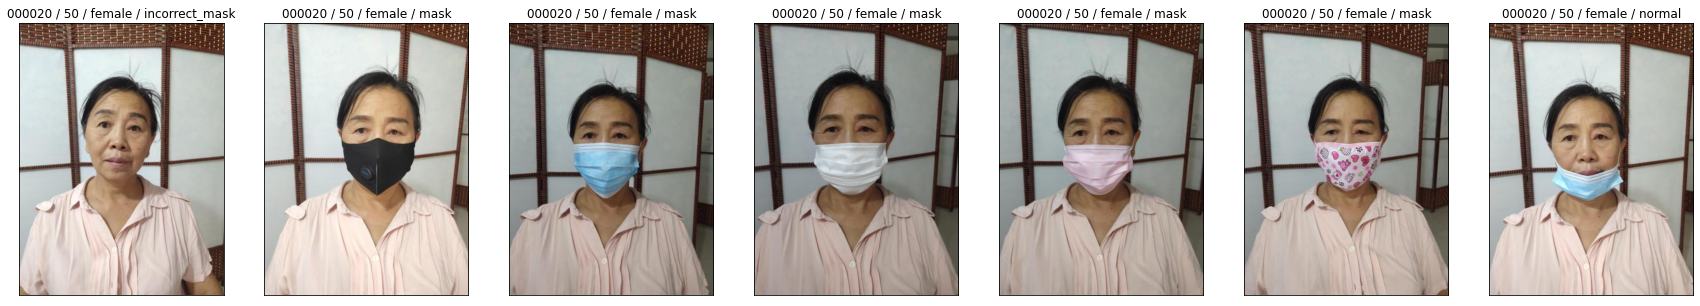

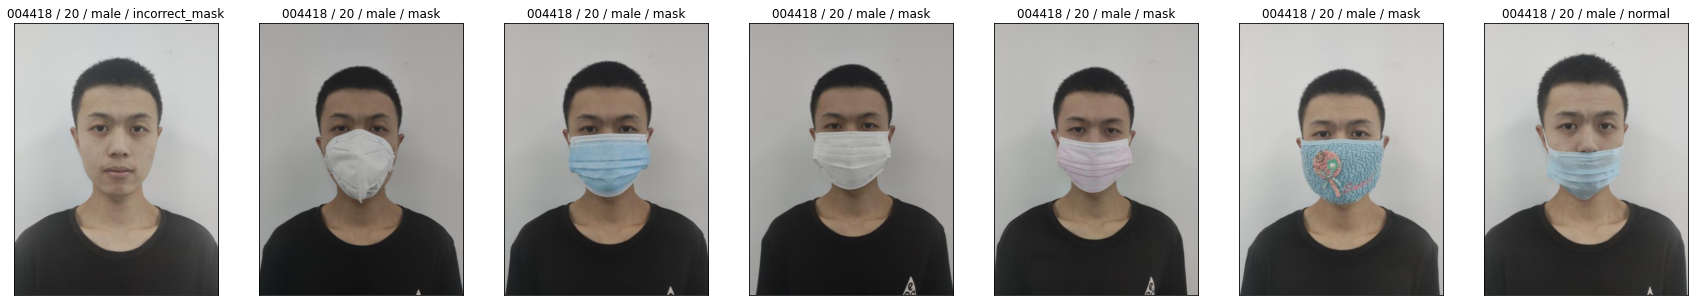

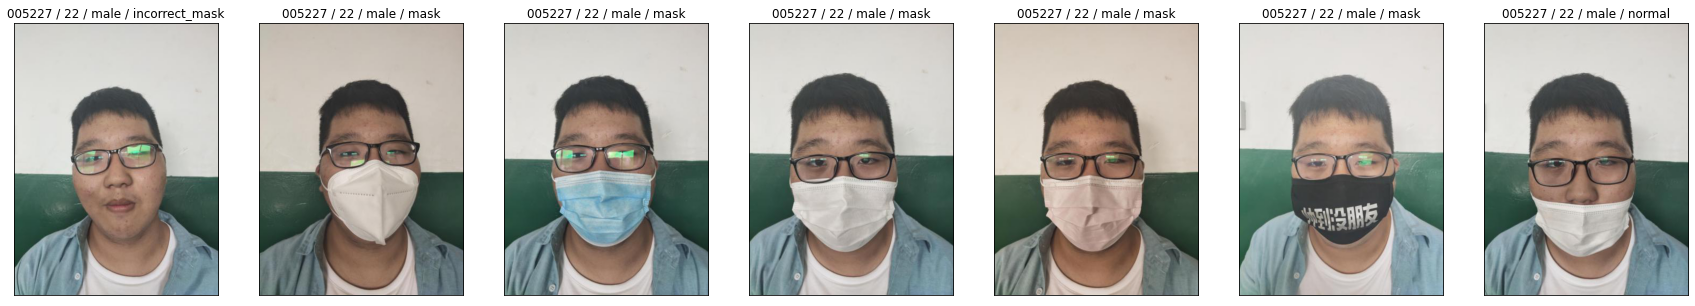

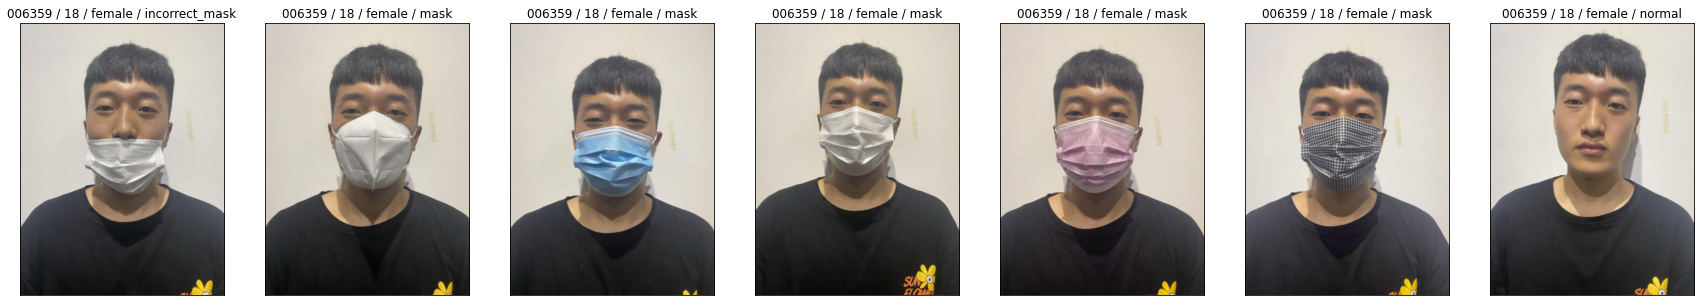

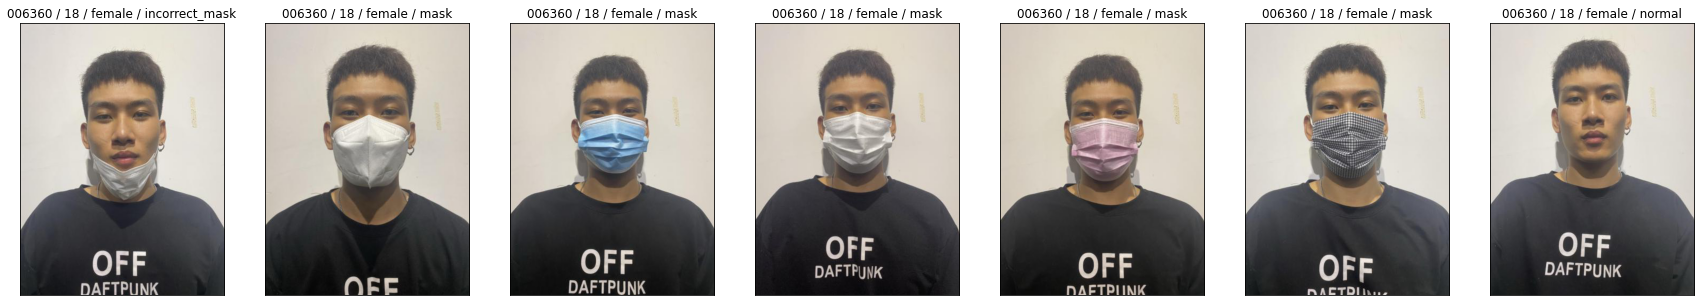

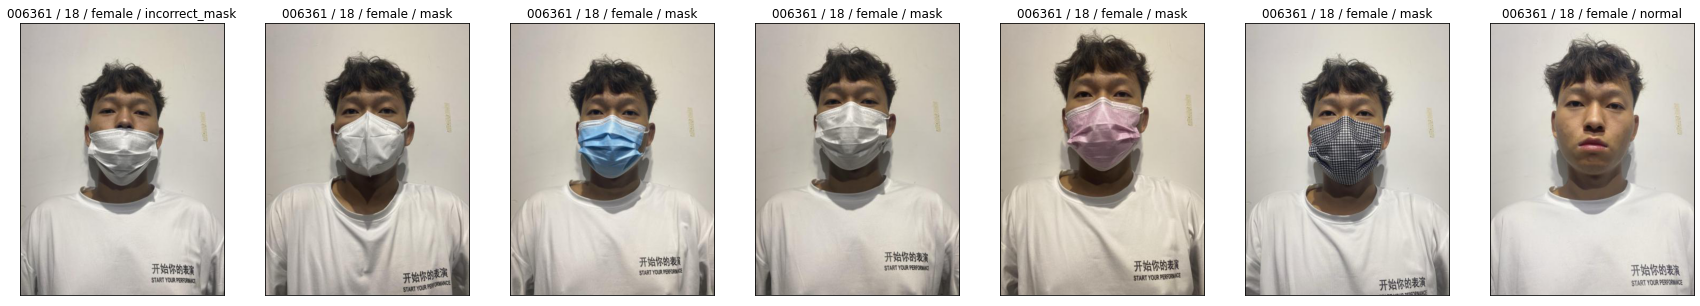

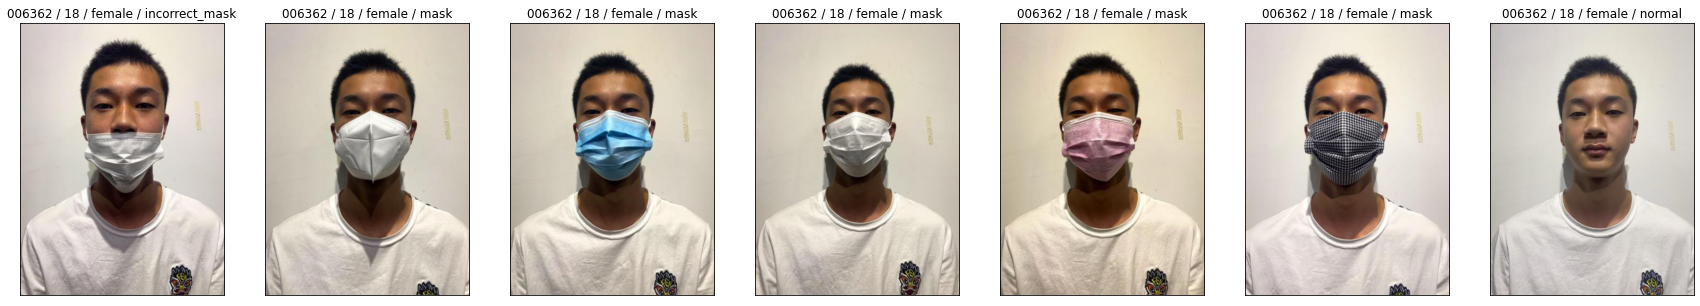

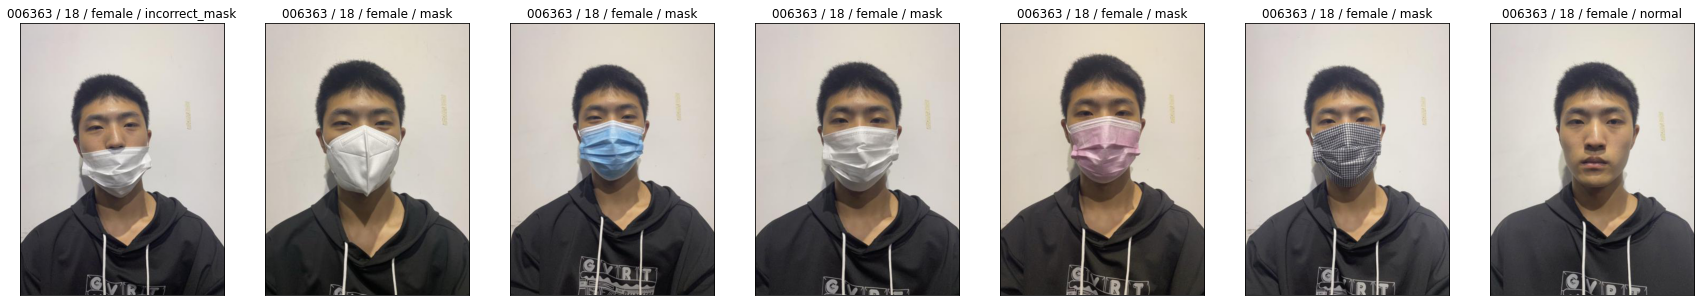

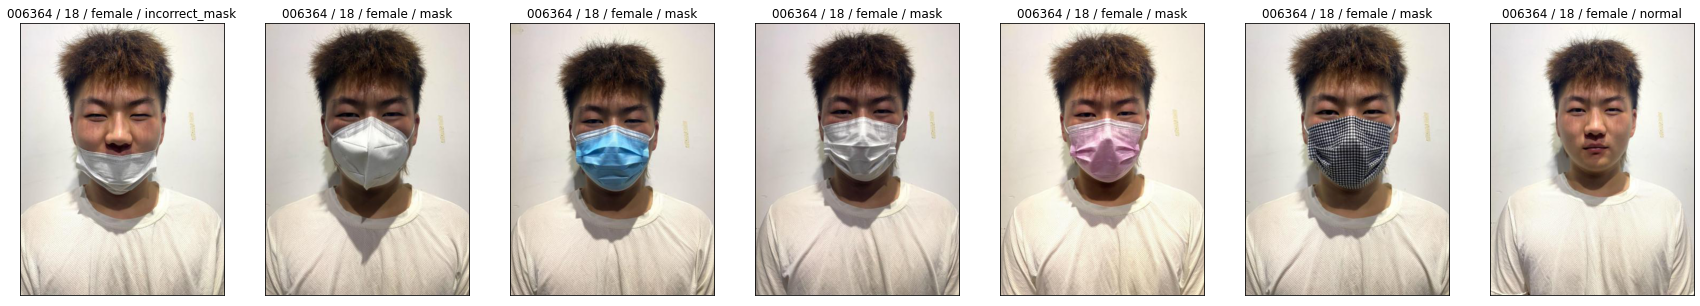

In [7]:
show_img(img_id_li =['000020', '004418', '005227', '006359', '006360', '006361', '006362', '006363', '006364'], df = df, data_dir = train_image_dir)

# 학습

In [8]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = get_train_df(df = pre_df)

train_df = swap_mask(swap_li = swap_mask_li, df = train_df)

In [9]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = get_train_df(df = pre_df)

train_df = swap_mask(swap_li = swap_mask_li, df = train_df)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = cv_taget_col)

total_start_time = time.time()

for fold_num in range(1, oof + 1):
    fold_start_time = time.time()
    
    # trn, val 데이터 셋
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[val_id_df['id'].tolist(), :].reset_index()
    trn_df = train_df.set_index('id').loc[trn_id_df['id'].tolist(), :].reset_index()
    
    # 이 부분에 클래스가 적은 데이터 증강 함수 추가
    ########################################3
    
    # 배치 단위 데이터 생성 부분
    #########################
    
    
    # dataset 구축
    trn_dataset = CustomDataset(df = trn_df, 
                                transform = transform, 
                                train = True)
    
    train_loder = DataLoader(trn_dataset,
                           batch_size = batch_size,
                           num_workers = num_workers,
                           shuffle = True,)
    
    
#     sampler = StratifiedSampler(y = np.array(trn_dataset.targets), 
#                                 batch_size = batch_size, 
#                                 shuffle = True)
    
#     train_loder = DataLoader(trn_dataset,
#                              num_workers = num_workers,
#                              batch_sampler = sampler)
    
    
    val_dataset = CustomDataset(df = val_df,
                                transform = transform, 
                                train = True,)
    
    val_loder = DataLoader(val_dataset,
                           batch_size = batch_size,
                           num_workers = num_workers,
                           shuffle = False,)
    
    # 모델 정의
    model = models.regnet_y_400mf(pretrained = True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, class_nums, bias = True)
    model = model.to(device)
    
    # loss 설정
    criterion = nn.CrossEntropyLoss()
    
    # optimizer 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # scheduler 설정
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, eps = 1e-09, patience = 5)
   
    # besf_metric 설정
    besf_fi = 0
    
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        
        train_loss, train_acc, train_fi_score = model_train(model = model, 
                                                            optimizer = optimizer, 
                                                            criterion = criterion, 
                                                            train_loder = train_loder)
        
        val_loss, val_acc, val_fi_score, = model_eval(model = model,
                                                      criterion = criterion,
                                                      val_loder = val_loder)
        
        # 학습률
        now_lr = get_lr(optimizer = optimizer)
        
        epoch_end_time = time.time()
        
        print(f'''{fold_num}fold, epoch: {epoch}, lr: {now_lr}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, train_f1: {train_fi_score:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}, val_fi: {val_fi_score:.4f}, 학습시간: {epoch_end_time - epoch_start_time} \n''')

        # 스케줄러
        scheduler.step(val_loss)
        
        # 모델 저장
        if besf_fi < val_fi_score:
            besf_fi = val_fi_score
            torch.save(model.state_dict(), os.path.join(model_dir, f'{fold_num}fold_regnet_y_400mf_OOF.pt'))
            print(besf_fi, '모델 저장')
    
    fold_end_time = time.time()
    
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time} \n')
    
    # 메모리 정리
    gc.collect()
    torch.cuda.empty_cache()

total_end_time = time.time()
print(f'총 훈련 시간: {total_end_time - total_start_time}')

1fold, epoch: 1, lr: 0.001, train_loss: 0.4080, train_acc: 0.8733, train_f1: 0.7190, val_loss: 0.9000, val_acc: 0.7383, val_fi: 0.5738, 학습시간: 95.04848718643188 

0.5737937277193107 모델 저장
1fold, epoch: 2, lr: 0.001, train_loss: 0.1164, train_acc: 0.9600, train_f1: 0.9033, val_loss: 0.4970, val_acc: 0.8511, val_fi: 0.6645, 학습시간: 93.7117850780487 

0.6644580418913104 모델 저장
1fold, epoch: 3, lr: 0.001, train_loss: 0.0655, train_acc: 0.9784, train_f1: 0.9440, val_loss: 1.1571, val_acc: 0.7623, val_fi: 0.5832, 학습시간: 94.52643060684204 

1fold, epoch: 4, lr: 0.001, train_loss: 0.0637, train_acc: 0.9804, train_f1: 0.9499, val_loss: 0.6188, val_acc: 0.8693, val_fi: 0.7236, 학습시간: 95.03454828262329 

0.7236303366924645 모델 저장
1fold, epoch: 5, lr: 0.001, train_loss: 0.0686, train_acc: 0.9796, train_f1: 0.9552, val_loss: 1.2956, val_acc: 0.7724, val_fi: 0.6174, 학습시간: 94.18525266647339 

1fold, epoch: 6, lr: 0.001, train_loss: 0.0417, train_acc: 0.9862, train_f1: 0.9696, val_loss: 0.7384, val_acc: 0.87

# 평가

In [10]:
def get_val_pred_li(model, data_loader):
    model.eval()
    real_pred_li = []
    label_pred_li = []
    ensemble_pred_li = []
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            output = model(images)
            
            label = output.argmax(dim=-1)
            label_pred_li.extend(label.cpu().numpy())
            
            ensemble_label = output.softmax(1)
            ensemble_pred_li.append(ensemble_label.cpu().numpy())
            
            real_pred_li.extend(targets.cpu().numpy())
    
    return label_pred_li, np.concatenate(ensemble_pred_li), real_pred_li

def get_submission_pred_li(model, data_loader):
    model.eval()
    label_pred_li = []
    ensemble_pred_li = []
    
    with torch.no_grad():
        for images in data_loader:
            images = images.to(device)
            output = model(images)
            
            label = output.argmax(dim=-1)
            label_pred_li.extend(label.cpu().numpy())
            
            ensemble_label = output.softmax(1)
            ensemble_pred_li.append(ensemble_label.cpu().numpy())
    
    return label_pred_li, np.concatenate(ensemble_pred_li)

In [12]:
# submission 데이터 정의
submission_dataset = CustomDataset(df = submission, 
                            transform = transform, 
                            train = False)

submission_loder = DataLoader(submission_dataset,
                                batch_size = batch_size,
                                num_workers = num_workers,
                                shuffle = False,)

submission_label_oof = np.zeros((submission.shape[0], 18))

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = cv_taget_col)

total_start_time = time.time()

real_labels = []
pred_labels = []

for fold_num in range(1, oof + 1):    
    # val
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[val_id_df['id'].tolist(), :].reset_index()
    trn_df = train_df.set_index('id').loc[trn_id_df['id'].tolist(), :].reset_index()
    
    val_dataset = CustomDataset(df = val_df, 
                                transform = transform, 
                                train = True,)
    
    val_loder = DataLoader(val_dataset,
                            batch_size = batch_size,
                           num_workers = num_workers,
                            shuffle = False,)
    
    # 모델 로드
    model = models.regnet_y_400mf(pretrained = False)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, class_nums, bias = True)
    model = model.to(device)
    model.load_state_dict(torch.load(os.path.join(model_dir, f'{fold_num}fold_regnet_y_400mf_OOF.pt'), map_location=device))
    
    # val 평가
    val_label_pred_li, val_ensemble_pred_li, real_pred_li = get_val_pred_li(model = model, data_loader = val_loder)
    
    real_labels += real_pred_li
    pred_labels += val_label_pred_li
    
    # submission 평가
    submission_label_pred_li, submission_ensemble_pred_li = get_submission_pred_li(model = model, data_loader = submission_loder)
    submission_label_oof += submission_ensemble_pred_li / oof

submission['ans'] = submission_label_oof.argmax(1).tolist()

In [13]:
train_f1 = get_f1_score(y_true = real_labels, y_pred = pred_labels)
train_acc = get_acc_score(y_true = real_labels, y_pred = pred_labels)
train_confusion_matrix = pd.DataFrame((confusion_matrix(y_true = real_labels, y_pred = pred_labels)))
print(f'train confusion_matrix')
display(train_confusion_matrix.style.background_gradient(cmap='YlOrRd', axis = 0))
print(f'train fi : {train_f1}, train acc: {train_acc} \n')

train confusion_matrix


train fi : 0.7967995066902952, train acc: 0.9030876599344401 



In [14]:
submission.to_csv(os.path.join(submission_data_dir, 'OOF_regnet_y_400mf_submission.csv'), index=False)
print('test inference is done!')

test inference is done!


In [15]:
submission.head()

ImageID  ans
0  cbc5c6e168e63498590db46022617123f1fe1268.jpg   13
1  0e72482bf56b3581c081f7da2a6180b8792c7089.jpg    1
2  b549040c49190cedc41327748aeb197c1670f14d.jpg   13
3  4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg   13
4  248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg   12